In [1]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import json
from ipywidgets import IntSlider, interact
from scipy import stats


In [2]:
# do that: conda install -c conda-forge umap-learn
import umap
from sklearn import preprocessing

In [3]:
#importing FAO data set
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

# Handling data
## 1) Fertilizer

In [4]:
fertilizer_area.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2002,2002,kg/ha,3.02,Fc


In [5]:
# Looking at the range of year covered by fertilizer dataframe
mini=min(fertilizer_area.Year)
maxi=max(fertilizer_area.Year)
print('Period of time covered by fertilizer_area : %d to %d'%(mini,maxi))

Period of time covered by fertilizer_area : 2002 to 2016


In [6]:
#looking at each type of fertilizer (and associated code)
ferti_items = pd.DataFrame({'Item':fertilizer_area['Item'].unique(), 'Item Code':fertilizer_area['Item Code'].unique()})
ferti_items

,Item,Item Code
0,Nutrient nitrogen N (total),3102
1,Nutrient phosphate P2O5 (total),3103
2,Nutrient potash K2O (total),3104


In [7]:
#missing value in fertilizer_area dataset
fertilizer_area[fertilizer_area.Value.isnull()]

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag


Is there really 0 missing value or is the value equal to zero when missing ?


In [8]:
fertilizer_area[fertilizer_area.Value ==0].head()

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
25,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2013,2013,kg/ha,0.0,Fc
26,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2014,2014,kg/ha,0.0,Fc
27,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2015,2015,kg/ha,0.0,Fc
28,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2016,2016,kg/ha,0.0,Fc
59,3,Albania,3104,Nutrient potash K2O (total),5159,Use per area of cropland,2002,2002,kg/ha,0.0,Fc


We can see some countries have 0 values for some years so let's take a deeper look :

In [9]:
fertilizer_area[fertilizer_area.Area == 'Afghanistan'].tail(15)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
14,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2016,2016,kg/ha,11.71,Fc
15,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2002,2002,kg/ha,0.35,Fc
16,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2003,2003,kg/ha,0.65,Fc
17,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2004,2004,kg/ha,1.53,Fc
18,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2005,2005,kg/ha,1.01,Fc
19,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2011,2011,kg/ha,0.20,Fc
20,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2012,2012,kg/ha,0.06,Fc
21,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2013,2013,kg/ha,0.19,Fc
22,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2014,2014,kg/ha,0.19,Fc
23,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,2015,2015,kg/ha,0.19,Fc


We only have 4 years for potash nutrient afghanistan's use so it looks like missing values.
How many values are in that situation ?

In [10]:
# Taking a look for Nitrogen nutrient
overall =fertilizer_area.query('`Item Code`==3102').shape
missing = fertilizer_area.query('Value==0').query('`Item Code`==3102').shape
missing_area=fertilizer_area.query('Value==0').query('`Item Code`==3102').Area.unique().shape
print('There are %d values with %d equal to zero from %d countries'%(overall[0],missing[0],missing_area[0]))

There are 2831 values with 26 equal to zero from 10 countries


In [11]:
# Taking a look for phosphate nutrient
overall =fertilizer_area.query('`Item Code`==3103').shape
missing = fertilizer_area.query('Value==0').query('`Item Code`==3103').shape
missing_area=fertilizer_area.query('Value==0').query('`Item Code`==3103').Area.unique().shape
print('There are %d values with %d equal to zero from %d countries'%(overall[0],missing[0],missing_area[0]))

There are 2800 values with 40 equal to zero from 17 countries


In [12]:
# Taking a look for potash nutrient
overall =fertilizer_area.query('`Item Code`==3104').shape
missing = fertilizer_area.query('Value==0').query('`Item Code`==3104').shape
missing_area=fertilizer_area.query('Value==0').query('`Item Code`==3104').Area.unique().shape

print('There are %d values with %d equal to zero from %d countries'%(overall[0],missing[0],missing_area[0]))

There are 2777 values with 56 equal to zero from 28 countries


There are only a few values missing. For country as afghanistan where we don't have any value, we can simply drop the country.

For the others values, one way to deal with them would be replacing them using interpolation. 
To do so we need also to look at the (missing values/total values) ratio for each country and if it is too high (thus interpolation would be meaningless) we should drop these values :

In [13]:
# Compute ratio of missing values for areas and items
ratio=[]
for item in ferti_items['Item Code'].values : 
    missing_area=fertilizer_area.query('Value==0').query('`Item Code`==@item').Area.unique()

    for area in missing_area :
        m=(fertilizer_area.query('Area==@area')
        .query('Value==0')
        .query('`Item Code`==@item')
        .Value.count())
        n=(fertilizer_area.query('Area==@area')
        .query('`Item Code`==@item')
        .Value.count())
        ratio.append([area,item,float(m/n)])

ratio=pd.DataFrame(ratio, columns=['Area','Item Code','Ratio'])
ratio.head()


,Area,Item Code,Ratio
0,Antigua and Barbuda,3102,0.066667
1,Benin,3102,0.066667
2,Libya,3102,0.066667
3,Lithuania,3102,0.133333
4,Marshall Islands,3102,1.000000


Now that we have our ratio dataset, let's drop or interpolate the missing values :

In [14]:
#interpolation of fertilizer missing values
na=fertilizer_area.query('Value == 0').shape
print("There were %d missing values"%na[0])

for item in ferti_items['Item Code'].values : 
    # Step 1 : drop area which have more than 50% of 0 values
    to_drop=fertilizer_area[fertilizer_area.Area.isin(ratio.query('Ratio>0.5 and `Item Code`==@item').Area)].query('`Item Code`==@item and Value == 0').index
    fertilizer_area.drop(to_drop,inplace=True)
    #Step 2 :creating 2 dataset : one contains area and year with missing value, the other is the dataset with all missing values dropped
    missing_ferti=fertilizer_area.query('Value == 0 and `Item Code` == @item')
    dropnan_ferti=fertilizer_area.query('Value != 0').query('`Item Code` ==@item')
    #step 3 : interpolation :
    for x in missing_ferti.Area.unique() :
        interpolation_coef = np.polyfit(dropnan_ferti.query('Area == @x').Year,dropnan_ferti.query('Area == @x').Value,1)
        poly = np.poly1d(interpolation_coef)
        to_replace=fertilizer_area.index[(fertilizer_area.Area==x)&(fertilizer_area['Item Code']==item)&(fertilizer_area.Value == 0)]
        replacing=poly(fertilizer_area.iloc[to_replace].Year)
        df=pd.DataFrame({'Value':replacing},index=to_replace)
        fertilizer_area.update(df,overwrite=True)

na=fertilizer_area.query('Value == 0').shape
print("There are %d missing values"%na[0])

#finaly replace negative value from interpolation by 0
to_replace=fertilizer_area.index[fertilizer_area.Value < 0]
fertilizer_area.loc[fertilizer_area.Value<0,'Value']=0

There were 122 missing values
There are 0 missing values


## 2) Crop dataset
First, lets take a look at yield for each country on year 2004 (arbitraly set)

In [15]:
crop_corr=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == 2004')
        .query('`Item Code` >1000')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
print(crop_corr.shape[0])
crop_corr.head()

244


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,12770.0,13348.0,78025.0,12106.0,3624.0,79157.0,3981.0,2725.0,10769.0,176471.0,12909.0,132255.0
1,Africa,13324.0,13988.0,90024.0,11963.0,3563.0,74572.0,3113.0,2716.0,5676.0,87147.0,6764.0,92421.0
2,Albania,34663.0,34663.0,74994.0,39264.0,2972.0,150953.0,3969.0,3713.0,10197.0,149346.0,46290.0,189790.0
3,Algeria,13440.0,13441.0,138702.0,13155.0,1426.0,50839.0,9834.0,4699.0,8049.0,203585.0,12473.0,131958.0
4,American Samoa,NaN,NaN,NaN,NaN,NaN,36975.0,1709.0,2777.0,NaN,35805.0,NaN,42432.0


We can see that there are some missing value (either due to missing values in the crops dataset or to unproduced crops by a country).
How many are there ?

In [16]:
# Checking in which columns values are missing for 1 year
print(crop_corr.isnull().sum()[crop_corr.isnull().sum()!=0])

Item
Cereals (Rice Milled Eqv)     27
Cereals,Total                 27
Citrus Fruit,Total            72
Coarse Grain, Total           31
Fibre Crops Primary           90
Fruit Primary                  6
Oilcrops, Cake Equivalent     18
Oilcrops, Oil Equivalent      16
Pulses,Total                  39
Roots and Tubers,Total         7
Treenuts,Total               100
Vegetables Primary             6
dtype: int64


We can expand that analysis at all the years :

In [17]:
miss_count=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area Code',columns='Item',values='Value')
        .reset_index()
          )
    keys=['Year','Total_row']+crop_year.columns.values.tolist()
    values=[year, crop_year.shape[0]]+crop_year.isnull().sum().values.tolist()
    dictionary = dict(zip(keys, values))
    df=pd.DataFrame.from_records([dictionary])
    miss_count=miss_count.append(df)
miss_count.sum()

C:\Users\juleb\.conda\envs\ada\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


Area Code                        0.0
Cereals (Rice Milled Eqv)      389.0
Cereals,Total                  389.0
Citrus Fruit,Total            1063.0
Coarse Grain, Total            448.0
Fibre Crops Primary           1154.0
Fruit Primary                   88.0
Oilcrops, Cake Equivalent      229.0
Oilcrops, Oil Equivalent       194.0
Pulses,Total                   554.0
Roots and Tubers,Total         103.0
Total_row                     3149.0
Treenuts,Total                1486.0
Vegetables Primary              88.0
Year                         30135.0
dtype: float64

### Interpolating missing value 
1) creating a dataset pointing to missing values and another with all missing value dropped

In [18]:
area_indexed=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed.head()

Area  Item Code  Element Code  \
Area Code Item                                                              
2         Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   

                                    Element  Year Code  Year   Unit    Value  \
Area Code Item                                                                 
2         Cereals (Rice Milled Eqv)   Yield       1961  1961  hg/ha  10831.0   
          Cereals (Rice Milled Eqv)   Yield       1962  1962  hg/ha  10480.0   
          Cereals (Rice Milled Eqv)   Yield       1963  1963  hg/ha   9548.0   
          Cereals (Rice Milled Eqv)   Yield       1964  1964  hg/ha  10461.0   
          Cereals (Rice Milled Eqv)   Yield       1965  1965  hg/ha  10621.0   

                                    Flag  
Area Code Item                            
2         Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc

In [19]:
ferti_range=pd.Series(range(2002,2016+1,1))
missing_values=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed.index.get_level_values(level=0).unique().values:
    for item in area_indexed.loc[area].index.unique().values:
        year_missing=ferti_range[~ferti_range.isin(area_indexed.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values =missing_values.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values.head()
        

,Area Code,Item,Year
0,2,Fibre Crops Primary,2015
1,2,Fibre Crops Primary,2016
2,2,"Oilcrops, Cake Equivalent",2015
3,2,"Oilcrops, Cake Equivalent",2016
4,2,"Oilcrops, Oil Equivalent",2015


In [20]:
missing_values.shape[0]

2807

In [21]:
#Now that cell must be useless (to remove in the next version but thing about updating next cell)
dropnan_crops=crops.dropna(axis=0, subset=['Value']).query('Year >= 2002 and `Element Code`==5419 and `Item Code` >1000')

2) Executing the interpolation

In [22]:
count=0
#Purpose of this code : adding missing value by interpolation 
for x in missing_values['Area Code'].unique():
    for j in missing_values.query('`Area Code` == @x')['Item'].unique():
        if dropnan_crops.query('`Area Code` == @x').query('`Item` == @j').shape[0]>=5 :
            interpolation_coef = np.polyfit(dropnan_crops.query('`Area Code` == @x').query('Item == @j').Year,
                                            dropnan_crops.query('`Area Code` == @x').query('Item == @j').Value,
                                            1)
            poly = np.poly1d(interpolation_coef)
            for year in missing_values.query('`Area Code` == @x').query('`Item` == @j').Year.values:
                interp_value=poly(year)
                template=dropnan_crops.query('`Area Code` == @x').query('`Item` == @j').head(1)
                to_add=template.values
                to_add[0][9]=interp_value
                to_add[0][6]=year
                to_add[0][7]=year
                to_add=pd.DataFrame(to_add,columns=template.columns.values)
                crops=crops.append(to_add,ignore_index=True)
                count+=1
                #t=t.append(to_add,ignore_index=True)
print(count)


1371


In [48]:
to_add=pd.DataFrame(to_add,columns=template.columns.values)
to_add

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,181,Zimbabwe,1732,"Oilcrops, Oil Equivalent",5419,Yield,2016,2016,hg/ha,1299.15,Fc


In [23]:
crops=crops.reset_index()
crops.drop(columns=['index'],axis=1, inplace=True)
crops.head(1)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,1975,1975,ha,0,F


3)  checking values changed

In [24]:
area_indexed2=crops.query('`Element Code` == 5419 and `Item Code` >1000 and `Area Code`<300').set_index(['Area Code', 'Item'])
area_indexed.head()

Area  Item Code  Element Code  \
Area Code Item                                                              
2         Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   
          Cereals (Rice Milled Eqv)  Afghanistan       1817          5419   

                                    Element  Year Code  Year   Unit    Value  \
Area Code Item                                                                 
2         Cereals (Rice Milled Eqv)   Yield       1961  1961  hg/ha  10831.0   
          Cereals (Rice Milled Eqv)   Yield       1962  1962  hg/ha  10480.0   
          Cereals (Rice Milled Eqv)   Yield       1963  1963  hg/ha   9548.0   
          Cereals (Rice Milled Eqv)   Yield       1964  1964  hg/ha  10461.0   
          Cereals (Rice Milled Eqv)   Yield       1965  1965  hg/ha  10621.0   

                                    Flag  
Area Code Item                            
2         Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc  
          Cereals (Rice Milled Eqv)   Fc

In [25]:
area_indexed2.shape[0]-area_indexed.shape[0]

1371

In [26]:
ferti_range=pd.Series(range(2002,2016+1,1))
missing_values2=pd.DataFrame(columns=['Area Code','Item','Year'])
for area in area_indexed2.index.get_level_values(level=0).unique().values:
    for item in area_indexed2.loc[area].index.unique().values:
        year_missing=ferti_range[~ferti_range.isin(area_indexed2.loc[area].loc[item].query('Year>=2002 and Year <=2016').Year)]
        for year in year_missing:
            missing_values2 =missing_values2.append({'Area Code':area,'Item':item,'Year':year},ignore_index=True)
missing_values2.head()

,Area Code,Item,Year
0,11,"Treenuts,Total",2002
1,11,"Treenuts,Total",2003
2,11,"Treenuts,Total",2004
3,11,"Treenuts,Total",2005
4,11,"Treenuts,Total",2006


In [56]:
miss_count2=pd.DataFrame()
for year in fertilizer_area.Year.unique():    
    crop_year=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == @year')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
    keys=['Year','Total_row']+crop_year.columns.values.tolist()
    values=[year, crop_year.shape[0]]+np.round(crop_year.isnull().sum().values).tolist()
    dictionary = dict(zip(keys, values))
    df=pd.DataFrame.from_records([dictionary])
    miss_count2=miss_count.append(df)
miss_count2.sum()



Area                             0.0
Area Code                        0.0
Cereals (Rice Milled Eqv)      415.0
Cereals,Total                  415.0
Citrus Fruit,Total            1134.0
Coarse Grain, Total            478.0
Fibre Crops Primary           1244.0
Fruit Primary                   94.0
Oilcrops, Cake Equivalent      248.0
Oilcrops, Oil Equivalent       210.0
Pulses,Total                   591.0
Roots and Tubers,Total         110.0
Total_row                     3361.0
Treenuts,Total                1586.0
Vegetables Primary              94.0
Year                         32151.0
dtype: float64

In [55]:
np.round(crop_year.isnull().sum().values).tolist()

[0, 26, 26, 71, 30, 90, 6, 19, 16, 37, 7, 100, 6]

In [33]:
miss_count

,Area Code,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Total_row,"Treenuts,Total",Vegetables Primary,Year
0,0,26,26,72,30,87.0,6,18.0,16.0,38,7,209,101,6,2002
0,0,26,26,72,30,87.0,6,18.0,16.0,37,7,209,101,6,2003
0,0,26,26,70,30,87.0,6,18.0,16.0,37,7,209,99,6,2004
0,0,26,26,70,30,87.0,6,18.0,16.0,37,7,209,99,6,2005
0,0,27,27,71,30,90.0,6,18.0,15.0,37,7,210,99,6,2006
0,0,26,26,71,30,89.0,6,18.0,15.0,37,7,210,99,6,2007
0,0,26,26,71,30,90.0,6,18.0,15.0,37,7,210,98,6,2008
0,0,26,26,71,30,89.0,6,18.0,15.0,37,7,210,98,6,2009
0,0,26,26,71,30,89.0,6,17.0,14.0,37,7,210,98,6,2010
0,0,26,26,71,30,89.0,6,17.0,14.0,37,7,210,98,6,2011


In [57]:
miss_count2

,Area,Area Code,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total",Total_row,"Treenuts,Total",Vegetables Primary,Year
0,NaN,0.0,26,26,72,30,87.0,6,18.0,16.0,38,7,209,101,6,2002
0,NaN,0.0,26,26,72,30,87.0,6,18.0,16.0,37,7,209,101,6,2003
0,NaN,0.0,26,26,70,30,87.0,6,18.0,16.0,37,7,209,99,6,2004
0,NaN,0.0,26,26,70,30,87.0,6,18.0,16.0,37,7,209,99,6,2005
0,NaN,0.0,27,27,71,30,90.0,6,18.0,15.0,37,7,210,99,6,2006
0,NaN,0.0,26,26,71,30,89.0,6,18.0,15.0,37,7,210,99,6,2007
0,NaN,0.0,26,26,71,30,90.0,6,18.0,15.0,37,7,210,98,6,2008
0,NaN,0.0,26,26,71,30,89.0,6,18.0,15.0,37,7,210,98,6,2009
0,NaN,0.0,26,26,71,30,89.0,6,17.0,14.0,37,7,210,98,6,2010
0,NaN,0.0,26,26,71,30,89.0,6,17.0,14.0,37,7,210,98,6,2011


The nan values are surprising, lets take a look at it for "Oilcrops, Cake Equivalent" column:

In [66]:
crop_year=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
        .query('`Year Code` == 2015')
        .query('`Item Code` >1000')
        .query('`Area Code` <300')
        .pivot(index='Area',columns='Item',values='Value')
        .reset_index()
          )
print(crop_year['Oilcrops, Cake Equivalent'].size)
print(crop_year[crop_year['Oilcrops, Cake Equivalent'].isnull()].shape[0])
crop_year[crop_year['Oilcrops, Cake Equivalent'].isnull()]

212
19


Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fibre Crops Primary,Fruit Primary,"Oilcrops, Cake Equivalent","Oilcrops, Oil Equivalent","Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
12,Bahrain,NaN,NaN,109455,NaN,NaN,40779,NaN,NaN,7336,207303,20591,318315
19,Bermuda,NaN,NaN,NaN,NaN,NaN,157026,NaN,NaN,NaN,212194,NaN,144961
25,British Virgin Islands,NaN,NaN,NaN,NaN,NaN,87899,NaN,NaN,NaN,NaN,NaN,NaN
34,Cayman Islands,NaN,NaN,NaN,NaN,NaN,12807,NaN,NaN,NaN,32911,NaN,23463
38,"China, Hong Kong SAR",13343,20004,NaN,NaN,NaN,133242,NaN,NaN,NaN,130706,NaN,226139
54,Djibouti,19047,19047,NaN,19047,NaN,NaN,NaN,NaN,3117,NaN,NaN,71771
65,Faroe Islands,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142774,NaN,NaN
87,Iceland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150833,NaN,1.14596e+06
101,Kuwait,65425,65425,213143,65663,NaN,341296,NaN,3558.77,NaN,752987,NaN,649325
106,Lesotho,6583,6583,NaN,6447,NaN,41104,NaN,NaN,2536,167724,NaN,89349


As we can see there are only 19 missing values, thus there is surely still an error in missing value count cell but the interpolation cell has worked

### Correlation between crops production

Text(0.5, 1, "Correlation matrix of the features of the dataset 'fifa_train'.")

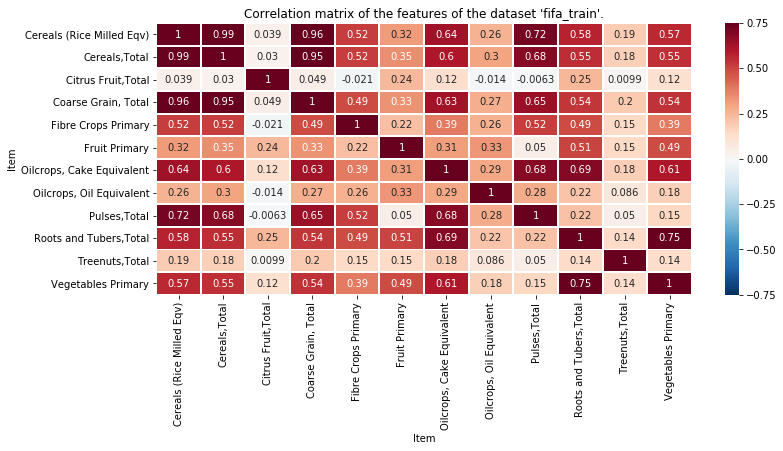

In [40]:
# To display correlation in the same order than our previous rank
correlation = crop_corr.corr()

# Plotting correlation map
plt.figure(figsize=(12,5))
heatmap = sns.heatmap(correlation, annot=True, linewidths=1, center=0,\
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
plt.title("Correlation matrix of the features of the dataset 'fifa_train'.")

Thus we will merge cereals

In [41]:
def ferti_class(x, L): #associate a color to each bin of fertilizer
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [42]:
def umap_year(year, ferti_code, n_components=2): 
    yield_for_merge=(crops.query('`Element Code` == 5419') #extraction of yield in crop dataset and pivot to have a df with each yield as a column (feature)
            .query('`Year Code` == @year')
            .query('`Item Code` >1000')
            .pivot(index='Area',columns='Item',values='Value')
            #.fillna(value=0) # decomment this and comment point 2 to get nan value replaced by 0
            .reset_index()
            .drop(columns=['Citrus Fruit,Total','Treenuts,Total','Fibre Crops Primary'])# drop columns with to many missing values
              )
    yield_for_merge['Cereal']=yield_for_merge.loc[:,['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total']].mean(axis=1)
    yield_for_merge.drop(columns=['Cereals (Rice Milled Eqv)','Cereals,Total','Coarse Grain, Total'])
    yield_for_merge=yield_for_merge.dropna(axis=0)
    #yield_for_merge.fillna(yield_for_merge.mean(), inplace = True) # point 2
    yield_for_umap=yield_for_merge.drop('Area',axis=1).values 
    
    #Normalization 
    x = yield_for_umap
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    yield_for_umap = pd.DataFrame(x_scaled)
    
    reducer = umap.UMAP(random_state=1, n_components= n_components)
    embedding = reducer.fit_transform(yield_for_umap)
    embedding2=pd.DataFrame(embedding)
    embedding2=pd.merge(embedding2,yield_for_merge['Area'], left_index=True, right_index=True)
    
    umap_fertilizer=(fertilizer_area
                    .query('Year == @year')
                    .query('`Area Code` <300')
                    .query('`Item Code` == @ferti_code')
                    .query('Value > 0')
                    .loc[:,['Area','Value']]
                    )
    embedding2=pd.merge(embedding2,umap_fertilizer,left_on='Area',right_on='Area')
    embedding2[0]=(embedding2[0]-min(embedding2[0]))/(max(embedding2[0])-min(embedding2[0]))
    embedding2['Value']=(embedding2['Value']-min(embedding2['Value']))/(max(embedding2['Value'])-min(embedding2['Value']))
    embedding2['ferti_class']=embedding2.Value.apply(lambda x: ferti_class(x, embedding2.Value))
    
    coef = np.polyfit(embedding2[0],embedding2.Value,1)
    
    return year,embedding2,coef # return year (for confirmation), performed umap and value of linear regression

LinregressResult(slope=-0.00350028124423987, intercept=7.0352850644950795, rvalue=-0.4981683295071354, pvalue=0.058768306061620035, stderr=0.0016897190078258356)
LinregressResult(slope=-0.007465661596125335, intercept=14.977580043281773, rvalue=-0.7643726239441664, pvalue=0.0009053444618933599, stderr=0.0017466244229940489)
LinregressResult(slope=-0.005294718518520414, intercept=10.694011486754318, rvalue=-0.24885450786127158, pvalue=0.3711168404376579, stderr=0.005715360697665858)


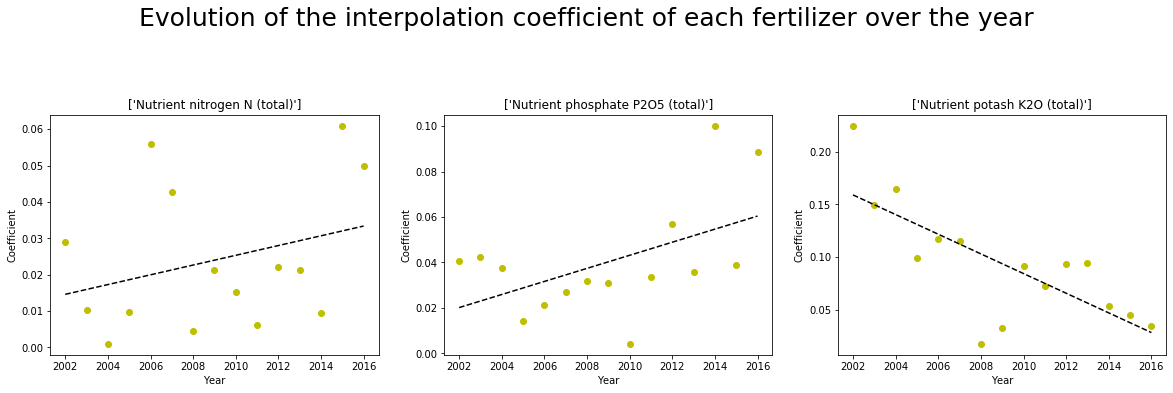

In [43]:
fig = plt.figure(figsize = (20, 15))
fig.suptitle('Evolution of the interpolation coefficient of each fertilizer over the year ', fontsize=25)
for x in range(3):
    mean=[]
    for year in fertilizer_area.pivot_table(index=['Year Code']).index :
        umap_result=umap_year(year,3102+x,1)
        mean.append([umap_result[0],umap_result[2][0]])
    mean=pd.DataFrame(mean)
    print(stats.linregress(mean[0],mean[1]))
    
    # look at coef over the years
    ax1 = fig.add_subplot(3,3,x+1)
    coef = np.polyfit(mean[0],abs(mean[1]),1) #test regression dim 1 ...
    poly1d_fn = np.poly1d(coef)
    plt.plot(mean[0],abs(mean[1]), 'yo',mean[0], poly1d_fn(mean[0]), '--k')
    
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    fertilizer=ferti_items.Item[ferti_items['Item Code']==3102+x].values
    plt.title('%s'%fertilizer)

0.029095170553194223 0.1085101256473526
-0.01020182448078035 0.11892344318976819
0.0009743054195799959 0.13168962204132537
-0.009822486816761173 0.12613641026802577
0.05587026727487977 0.13855322698655903
0.042750435173576996 0.1455456112557884
0.0044389596970714025 0.11682821401750516
0.02130077951027322 0.13595845789671393
-0.015254643712757688 0.13928579805600258
0.006193860057967287 0.14085694760399523
0.02219974443149889 0.1588842185961094
0.021178292712168346 0.1464041849234596
-0.009564261620796525 0.16318271269919213
-0.06089001944778103 0.19345191522034896
-0.04996790649363491 0.18917000959197908


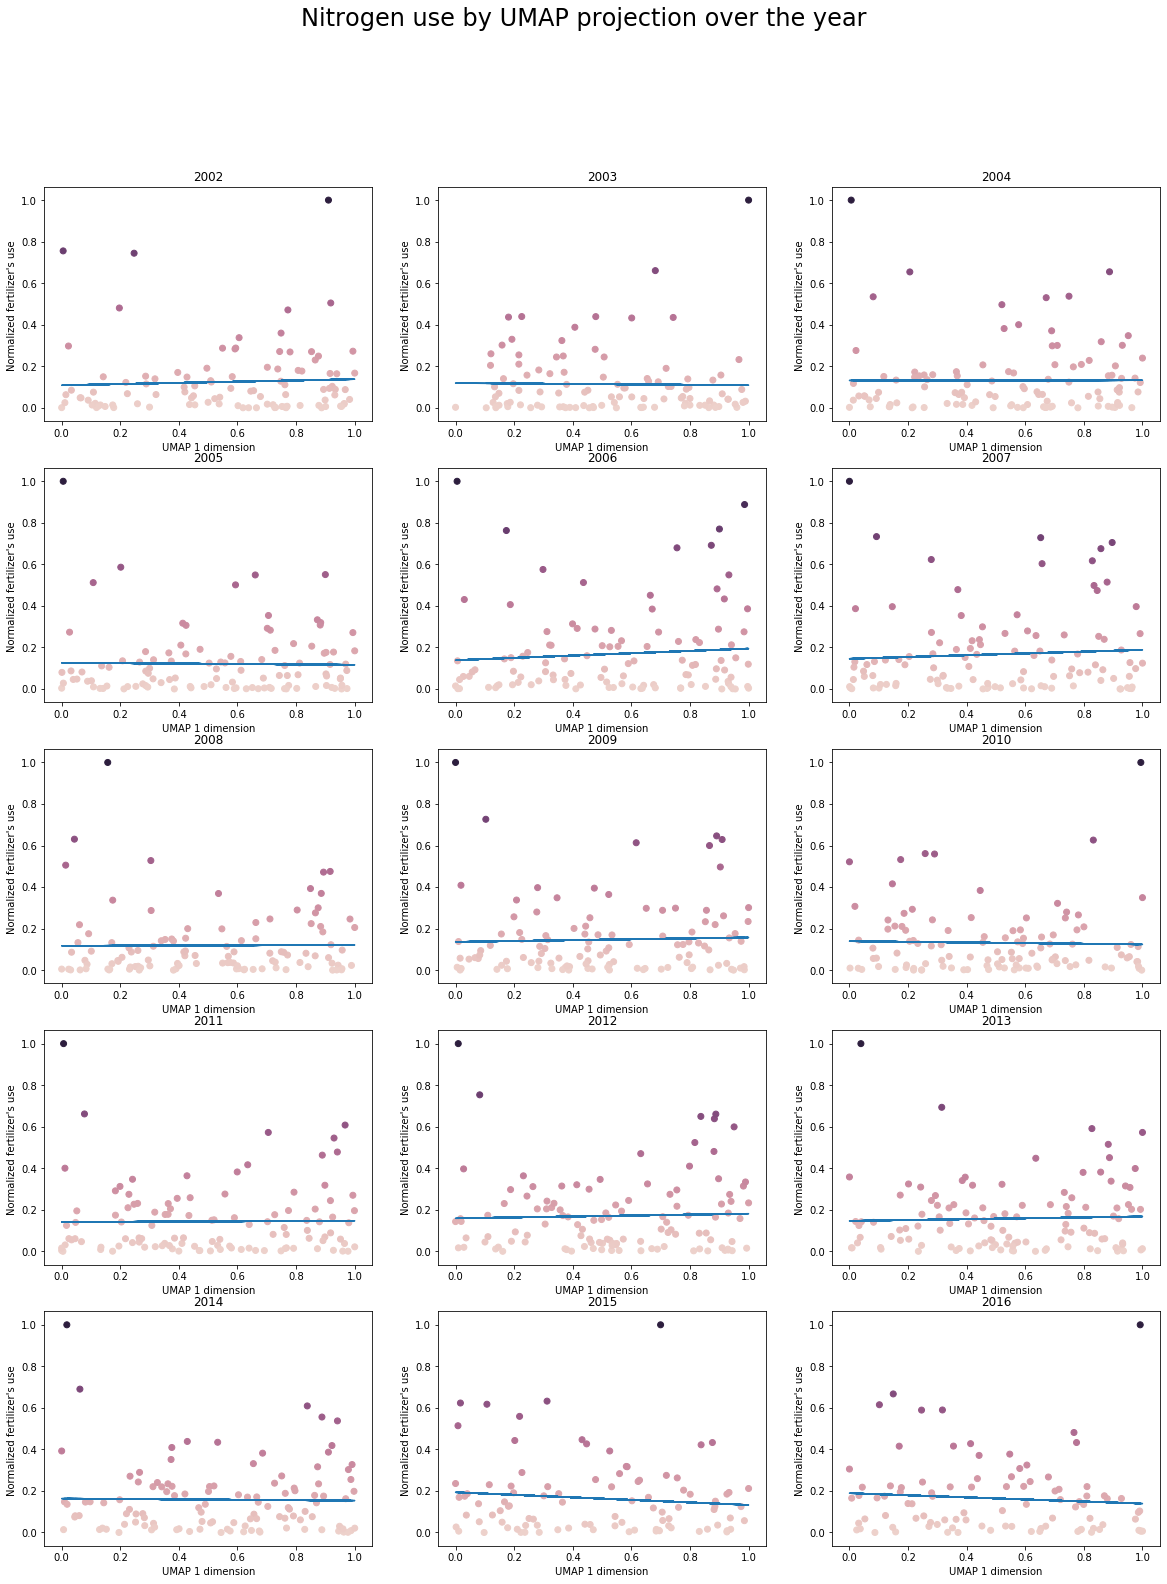

In [67]:
#plot for multiple years for Nutrient nitrogen N vs umap
year=fertilizer_area['Year Code'].unique()
n=len(year)
fig = plt.figure(figsize = (20, math.ceil(n/3)*5 ))
fig.suptitle('Nitrogen use by UMAP projection over the year', fontsize=24)
for x in range (n) : 
    vis_2016=umap_year(year[x], 3102, 1)
    ax1 = fig.add_subplot(math.ceil(n/3),3,x+1)
    embedding2=vis_2016[1] 
    coef = vis_2016[2]
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = embedding2.Value
    print(coef[0],coef[1])
    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(embedding2[0], embedding2.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(embedding2[0], poly1d_fn(embedding2[0]))
    plt.title('%d'%year[x]);
    plt.xlabel("UMAP 1 dimension")
    plt.ylabel("Normalized fertilizer's use ")